In [24]:
!pip install osmnx

In [25]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import pandas as pd
import time

# Ensure plots are shown inline in notebooks
%matplotlib inline

In [4]:
ox.__version__

'2.0.6'

In [5]:
nx.__version__

'3.5'

In [27]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

Heuristicas

In [28]:
def heuristic_great_circle(G, u, v):
    """
    Heurística baseada em astar.py (que usa great_circle)
    Assume que os nós u e v estão no grafo G (não-projetado, com lat/lon).
    """
    u_node = G.nodes[u]
    v_node = G.nodes[v]
    # Esta linha é a lógica da heurística de astar.py
    return ox.distance.great_circle(
        u_node['y'], u_node['x'],
        v_node['y'], v_node['x']
    )

In [32]:
def processar_cidade_mst(city_name, poi_tags):
    """
    Esta função encapsula toda a lógica de kruskal_natal.py,
    mas será modificada para usar A*.
    """
    print(f"\n--- Iniciando Processamento para: {city_name} ---")

    try:
        # 1. Obter o grafo da cidade
        # (Copiado de kruskal_natal.py)
        print("Baixando grafo viário...")
        G = ox.graph_from_place(city_name, network_type='drive')

        # Converte para não-direcionado (de kruskal_natal.py)
        G_undirected = to_undirected_multigraph(G)

        # 2. Obter POIs de interesse
        # (Copiado de kruskal_natal.py)
        print("Buscando POIs")
        pois = ox.features.features_from_place(city_name, tags=poi_tags)

        # Extrair pontos representativos (de kruskal_natal.py)
        poi_points = []
        for idx, row in pois.iterrows():
            if row.geometry.geom_type == 'Point':
                poi_points.append((row.geometry.y, row.geometry.x))
            else:
                poi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

        if not poi_points:
            print(f"Nenhum POI encontrado para {city_name}.")
            return None # Pula esta cidade

        # 3. Encontrar nós mais próximos dos POIs
        # (Copiado de kruskal_natal.py)
        print("Encontrando nós do grafo mais próximos...")
        latitudes = [hp[0] for hp in poi_points]
        longitudes = [hp[1] for hp in poi_points]
        hospital_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
        hospital_nodes = list(set(hospital_nodes)) # Remover duplicatas

        if len(hospital_nodes) < 2:
            print(f"POIs insuficientes (encontrados {len(hospital_nodes)}) para MST.")
            return None # Pula esta cidade

        print(f"Encontrados {len(hospital_nodes)} nós de POI únicos.")

        # 4. Construir um grafo completo com menor rota entre POIs
        # AQUI OCORRE (A* + Kruskal)
        print("Calculando rotas A* entre todos os pares de POIs (isso pode demorar)...")
        G_interest = nx.Graph()

        # Dicionário para guardar as rotas e usá-las na plotagem
        rotas_calculadas = {}

        for i in range(len(hospital_nodes)):
            for j in range(i + 1, len(hospital_nodes)):
                u = hospital_nodes[i]
                v = hospital_nodes[j]

                try:
                    h = lambda n1, n2: heuristic_great_circle(G_undirected, n1, n2)

                    route = nx.astar_path(
                        G_undirected,
                        u,
                        v,
                        heuristic=h,
                        weight='length' # Otimizando por distância
                    )

                    # Calcular o comprimento da rota
                    route_length = 0
                    for k in range(len(route) - 1):
                        # Pega a aresta de menor comprimento entre os nós
                        # (necessário por ser MultiGraph)
                        edge_data = G_undirected.get_edge_data(route[k], route[k+1])
                        min_length = min(data['length'] for data in edge_data.values())
                        route_length += min_length

                    G_interest.add_edge(u, v, weight=route_length)
                    rotas_calculadas[(u, v)] = route # Salva a rota para a plotagem

                except nx.NetworkXNoPath:
                    print(f"AVISO: Nenhum caminho encontrado entre os nós {u} e {v}.")

        # 5. Calcular o MST
        print("Calculando a MST sobre o grafo de POIs...")
        mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
        total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])

        print(f"Comprimento total da MST: {total_mst_length:.2f} metros")

        # Mapear as arestas da MST de volta para as rotas A* que guardamos
        mst_routes = []
        for (u, v, d) in mst_edges:
            if (u, v) in rotas_calculadas:
                mst_routes.append(rotas_calculadas[(u, v)])
            elif (v, u) in rotas_calculadas:
                mst_routes.append(rotas_calculadas[(v, u)])
            # else: não deveria acontecer

        # 6. Empacotar resultados para a tabela e plotagem
        num_pois = len(hospital_nodes)
        num_arestas_mst = len(mst_edges)

        stats = {
            "Cidade": city_name.split(',')[0], # Pega só o nome da cidade
            "Nós de POI": num_pois,
            "Arestas na MST": num_arestas_mst,
            "Comprimento MST (km)": total_mst_length / 1000.0,
            "Média km/POI": (total_mst_length / 1000.0) / num_pois if num_pois > 0 else 0,
            "Média km/Aresta": (total_mst_length / 1000.0) / num_arestas_mst if num_arestas_mst > 0 else 0,
            # Guardar os objetos para plotar depois
            "_G_undirected": G_undirected,
            "_poi_nodes": hospital_nodes,
            "_mst_routes": mst_routes
        }

        print(f"Processamento de {city_name} concluído.")
        return stats

    except Exception as e:
        print(f"ERRO GERAL ao processar {city_name}: {e}")
        return None

In [33]:
#Capitais do Nordeste

# SEÇÃO PRINCIPAL: Execução e Comparação

# 1. Definir Cidades e POIs
cities = [
    "Natal, Rio Grande do Norte, Brazil",     #
    "Fortaleza, Ceará, Brazil",
    "Salvador, Bahia, Brazil",
    "Recife, Pernambuco, Brazil",
    "São Luís, Maranhão, Brazil",
    "Maceió, Alagoas, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "Teresina, Piauí, Brazil",
    "Aracaju, Sergipe, Brazil"
]

poi_tags = {'tourism': 'museum'}

# 2. Loop de processamento
print("Iniciando o processamento de todas as cidades...")
all_results = []
for city in cities:
    start_time = time.time()
    city_stats = processar_cidade_mst(city, poi_tags)
    if city_stats:
        all_results.append(city_stats)
    end_time = time.time()
    print(f"Tempo de {city.split(',')[0]}: {end_time - start_time:.2f} segundos.")

print("\nProcessamento de todas as cidades concluído.")

Iniciando o processamento de todas as cidades...

--- Iniciando Processamento para: Natal, Rio Grande do Norte, Brazil ---
Baixando grafo viário...
Buscando POIs
Encontrando nós do grafo mais próximos...
Encontrados 13 nós de POI únicos.
Calculando rotas A* entre todos os pares de POIs (isso pode demorar)...
Calculando a MST sobre o grafo de POIs...
Comprimento total da MST: 19626.68 metros
Processamento de Natal, Rio Grande do Norte, Brazil concluído.
Tempo de Natal: 22.53 segundos.

--- Iniciando Processamento para: Fortaleza, Ceará, Brazil ---
Baixando grafo viário...
Buscando POIs
Encontrando nós do grafo mais próximos...
Encontrados 18 nós de POI únicos.
Calculando rotas A* entre todos os pares de POIs (isso pode demorar)...
Calculando a MST sobre o grafo de POIs...
Comprimento total da MST: 37280.06 metros
Processamento de Fortaleza, Ceará, Brazil concluído.
Tempo de Fortaleza: 54.63 segundos.

--- Iniciando Processamento para: Salvador, Bahia, Brazil ---
Baixando grafo viário...

In [34]:
# 3. Criar tabela comparativa
if all_results:
    # Criar um DataFrame pandas para a tabela
    df = pd.DataFrame(all_results)

    # Selecionar e reordenar colunas para a tabela
    table_cols = [
        "Cidade",
        "Nós de POI",
        "Comprimento MST (km)",
        "Média km/POI",
        "Média km/Aresta"
    ]
    df_table = df[table_cols].copy().set_index("Cidade")

    print("\n\n" + "="*80)
    print("TABELA COMPARATIVA CONSOLIDADA (A* + MST)")
    print("="*80)
    # Formatar os números flutuantes para 2 casas decimais
    print(df_table.to_string(float_format="%.2f"))
    print("="*80)
else:
    print("Nenhum resultado foi gerado para a tabela.")



TABELA COMPARATIVA CONSOLIDADA (A* + MST)
             Nós de POI  Comprimento MST (km)  Média km/POI  Média km/Aresta
Cidade                                                                      
Natal                13                 19.63          1.51             1.64
Fortaleza            18                 37.28          2.07             2.19
Salvador             36                 41.24          1.15             1.18
Recife               27                 26.75          0.99             1.03
São Luís             19                 27.40          1.44             1.52
Maceió               10                  6.09          0.61             0.68
João Pessoa          11                 27.66          2.51             2.77
Teresina              8                 12.28          1.54             1.75
Aracaju               5                  8.08          1.62             2.02



Gerando visualizações para cada cidade...
Plotando Natal...


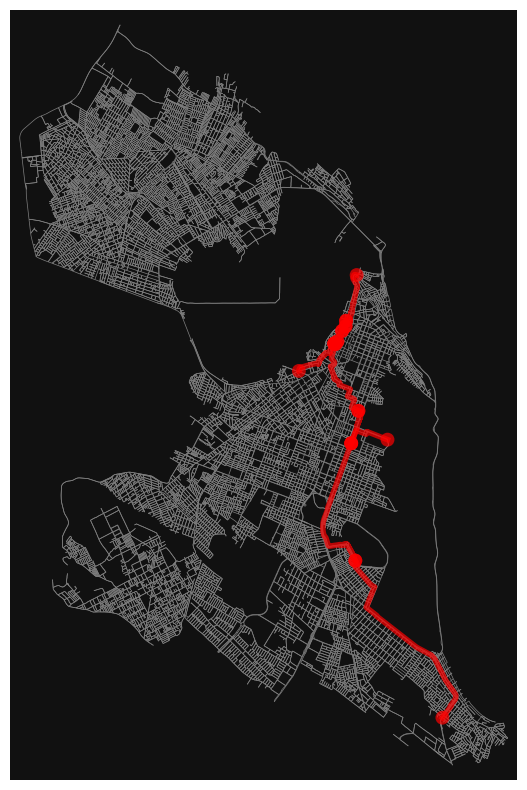

Plotando Fortaleza...


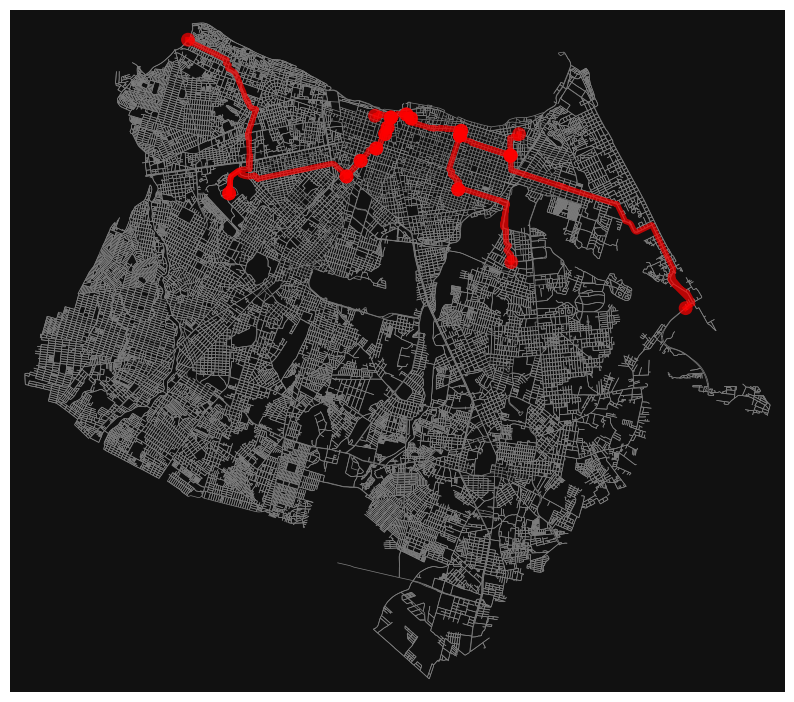

Plotando Salvador...


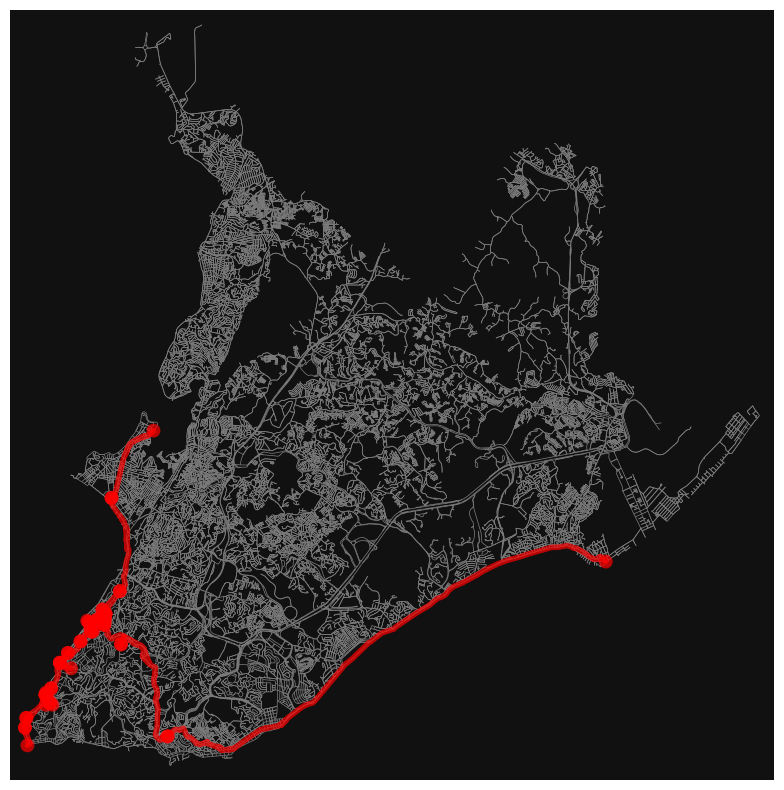

Plotando Recife...


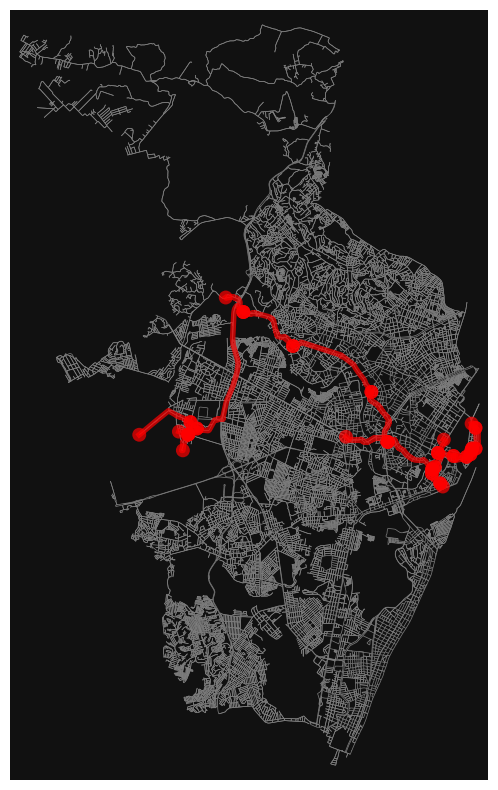

Plotando São Luís...


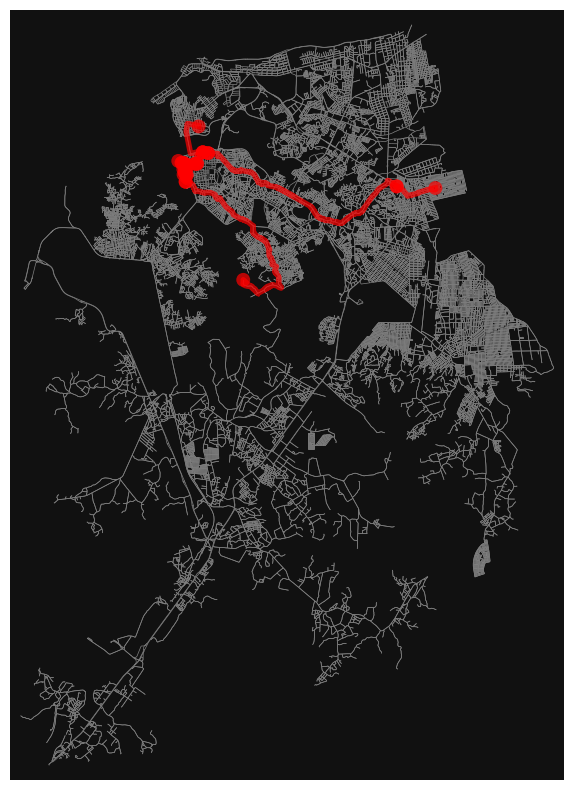

Plotando Maceió...


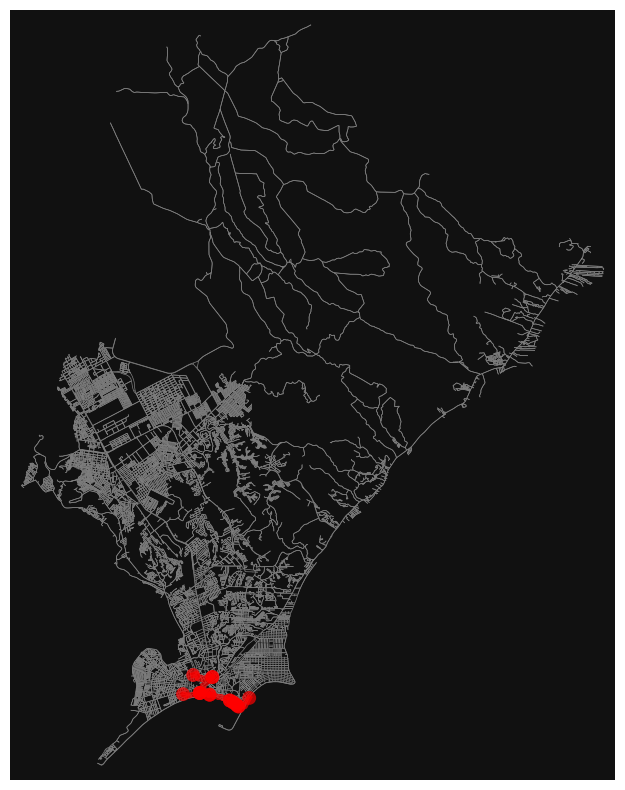

Plotando João Pessoa...


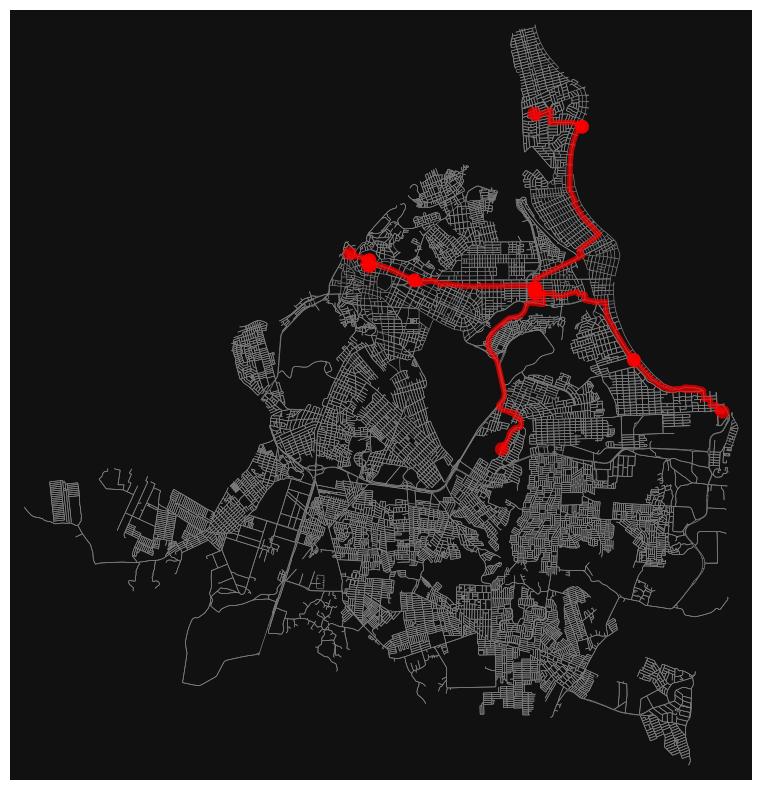

Plotando Teresina...


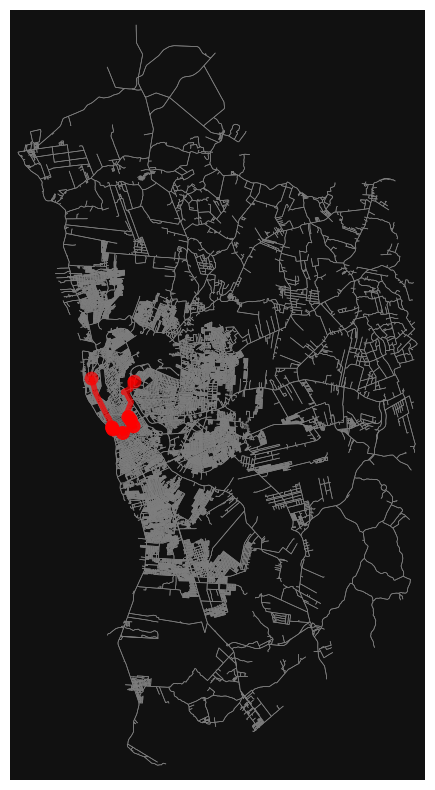

Plotando Aracaju...


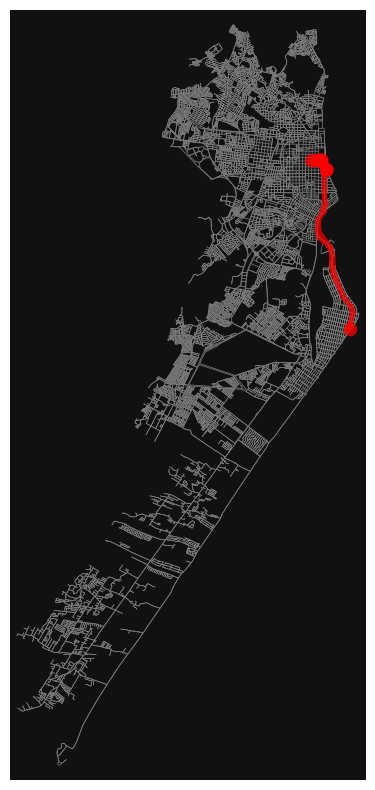

In [35]:
# 4. Plotar os resultados
print("\nGerando visualizações para cada cidade...")

if all_results:
    for res in all_results:
        city_name_short = res["Cidade"]
        print(f"Plotando {city_name_short}...")

        # Pegar os dados guardados
        G_plot = res["_G_undirected"]
        routes_plot = res["_mst_routes"]
        pois_plot = res["_poi_nodes"]

        # 1. Plotar o grafo base (mapa de ruas cinza)
        fig, ax = ox.plot_graph(
            G_plot,
            node_size=0,
            edge_color="gray",
            edge_linewidth=0.5,
            show=False,
            close=False,
            figsize=(10, 10)
        )

        # 2. Plotar TODAS as rotas da MST de UMA SÓ VEZ (Otimizado)
        if routes_plot:
            ox.plot_graph_routes(
                G_plot,
                routes_plot,      # A lista inteira de rotas
                route_color='red',
                route_linewidth=1.0,
                route_alpha=0.7,
                ax=ax
            )

        # 3. Plotar os POIs (museus) em azul
        poi_x = [G_plot.nodes[n]['x'] for n in pois_plot]
        poi_y = [G_plot.nodes[n]['y'] for n in pois_plot]
        ax.scatter(poi_x, poi_y, c='blue', s=50, zorder=5, edgecolor='black', alpha=0.8, label="POIs (Museus)")

        # 4. Finalizar e mostrar o gráfico
        ax.set_title(f"MST (A*) entre Museus em {city_name_short}", fontsize=14)
        ax.legend(loc='upper right')
        plt.show()
else:
    print("Nenhum resultado para plotar.")

In [22]:
all_results[0]['_mst_routes']

[[np.int64(300392670), 8945996908],
 [np.int64(529717461), 8630021496],
 [np.int64(8630308660), 301648633, 301648632, 301648631, 6988402658],
 [np.int64(505803857), 560213482, 560213486, 560213485],
 [np.int64(529717461), 529717599, 529714016, 302602038, 8626703483],
 [np.int64(7271737126), 526598507, 529717461],
 [np.int64(526598445),
  8626076013,
  8626076014,
  529717460,
  8630021498,
  8630021496],
 [np.int64(8945996908), 3801069356, 300389756, 560213486, 560213485],
 [np.int64(7271872818),
  302603013,
  6988402601,
  6988402594,
  6988402597,
  6412936712,
  5041191867],
 [np.int64(5041191867),
  5041191846,
  5041191848,
  302602041,
  6988402582,
  529717600,
  529717460,
  8630021498,
  8630021496],
 [np.int64(7271737126),
  526598510,
  6988402554,
  6988402552,
  6988402553,
  526598548,
  1430622936],
 [np.int64(7243939552),
  7246715375,
  7246715374,
  7244180148,
  7246600471,
  8627157423,
  302594911],
 [np.int64(302603017),
  302603025,
  5967864961,
  302592197,
  